In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def process_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (100, 100))
    return np.mean(img)

def collect_data(city_folder, city_name):
    data = []
    for fname in os.listdir(city_folder):
        match = re.match(r"viirs_(\d{4})_(\d{1,2})", fname)
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            image_path = os.path.join(city_folder, fname)
            intensity = process_image(image_path)
            if intensity is not None:
                data.append({"Oras": city_name, "An": year, "Luna": month, "Intensitate": intensity})
    return data

base_path = "/content/drive/MyDrive"  # <-- schimbă cu folderul tău
folders = {
    "Dubai": os.path.join(base_path, "dubai"),
    "Washington": os.path.join(base_path, "washington"),
    "NYC": os.path.join(base_path, "nyc")
}

all_data = []
for city, path in folders.items():
    all_data += collect_data(path, city)

df = pd.DataFrame(all_data)
df = df.sort_values(["Oras", "An", "Luna"]).reset_index(drop=True)



📊 Rezultate Dubai pentru 2024
MAE: 1.41
RMSE: 1.56
R²: -0.56
Precizie: 69.51%
Acuratețe (eroare <10%): 8.33%


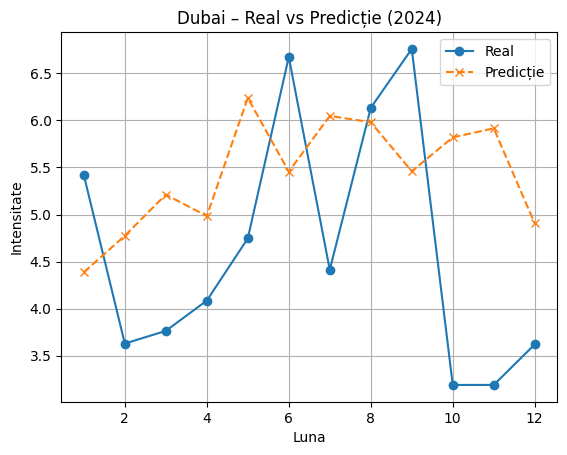


📊 Rezultate NYC pentru 2024
MAE: 1.51
RMSE: 2.08
R²: 0.22
Precizie: 77.12%
Acuratețe (eroare <10%): 33.33%


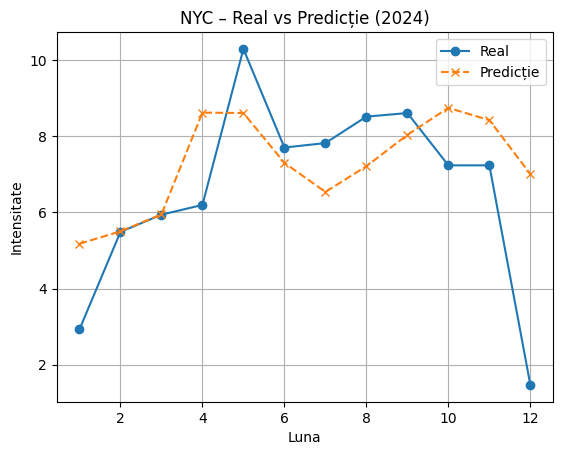


📊 Rezultate Washington pentru 2024
MAE: 1.94
RMSE: 2.46
R²: 0.07
Precizie: 77.47%
Acuratețe (eroare <10%): 41.67%


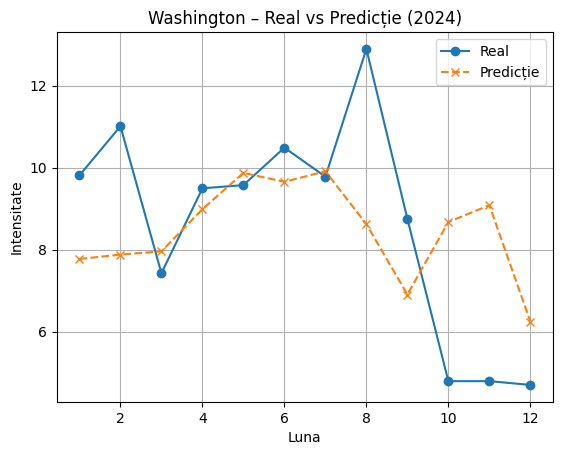

In [ ]:
results = {}
for city in df["Oras"].unique():
    df_city = df[df["Oras"] == city]
    train = df_city[df_city["An"] < 2024]
    test = df_city[df_city["An"] == 2024]

    X_train = train[["An", "Luna"]]
    y_train = train["Intensitate"]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predicții 2024
    future = pd.DataFrame({
        "An": [2024]*12,
        "Luna": list(range(1, 13))
    })
    future["Oras"] = city
    future["Predicted"] = model.predict(future[["An", "Luna"]])
    results[city] = (future, model)

    # Evaluare dacă avem și valori reale pentru 2024
    if not test.empty:
        y_true = test.sort_values("Luna")["Intensitate"].values
        y_pred = future.sort_values("Luna")["Predicted"].values

        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        avg_real = np.mean(y_true)
        precision = 1 - (mae / avg_real)
        accuracy = np.mean(np.abs(y_true - y_pred) / y_true < 0.1) * 100

        print(f"\n📊 Rezultate {city} pentru 2024")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"R²: {r2:.2f}")
        print(f"Precizie: {precision*100:.2f}%")
        print(f"Acuratețe (eroare <10%): {accuracy:.2f}%")

        # Grafic
        plt.plot(range(1, 13), y_true, label="Real", marker='o')
        plt.plot(range(1, 13), y_pred, label="Predicție", marker='x', linestyle='--')
        plt.title(f"{city} – Real vs Predicție (2024)")
        plt.xlabel("Luna")
        plt.ylabel("Intensitate")
        plt.grid(True)
        plt.legend()
        plt.show()


In [ ]:
for city in df["Oras"].unique():
    print(f"\n🌆 Valori reale 2024 – {city}")
    df_2024 = df[(df["Oras"] == city) & (df["An"] == 2024)].sort_values("Luna")
    if not df_2024.empty:
        print(df_2024[["Luna", "Intensitate"]].to_string(index=False))
    else:
        print("❌ Nu există date reale pentru 2024.")



🌆 Valori reale 2024 – Dubai
 Luna  Intensitate
    1       5.4182
    2       3.6293
    3       3.7637
    4       4.0854
    5       4.7461
    6       6.6735
    7       4.4133
    8       6.1331
    9       6.7588
   10       3.1898
   11       3.1898
   12       3.6201

🌆 Valori reale 2024 – NYC
 Luna  Intensitate
    1       2.9269
    2       5.4869
    3       5.9403
    4       6.1960
    5      10.2936
    6       7.7038
    7       7.8209
    8       8.5155
    9       8.6092
   10       7.2359
   11       7.2359
   12       1.4690

🌆 Valori reale 2024 – Washington
 Luna  Intensitate
    1       9.8084
    2      11.0089
    3       7.4221
    4       9.4936
    5       9.5715
    6      10.4855
    7       9.7771
    8      12.8939
    9       8.7495
   10       4.7896
   11       4.7896
   12       4.6978


In [ ]:
import joblib

# Salvează modelul antrenat
joblib.dump(model, '/content/drive/MyDrive/best_rf_model.pkl')  # Salvează modelul pe Google Drive


['/content/drive/MyDrive/best_rf_model.pkl']